#### LiuID: Hodfa840
#### name: Hoda

In [14]:
import torch
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import warnings
warnings.filterwarnings('ignore')


In [15]:
class NormalDataset(Dataset):
    def __init__(self, samples, mean, std):
        self.mean = mean
        self.std = std
        rng = default_rng()
        self.data = rng.normal(loc = self.mean, scale = self.std, size=samples)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]

In [16]:
rng = default_rng()
mean = 0
std = 1

def generate_noise(length):
    return rng.uniform(mean, std, length)

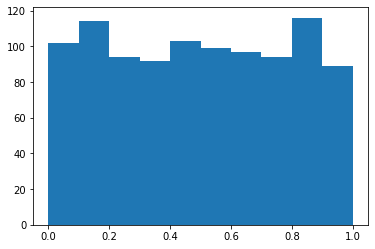

In [17]:
plt.hist(generate_noise(1000))
plt.show()

In [18]:
data = NormalDataset(10000, 0, 1)

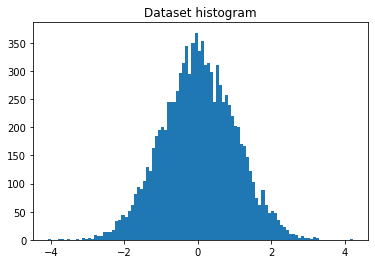

In [19]:
plt.hist(data, bins=100)
plt.title('Dataset histogram')
plt.show()

In [20]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [22]:
n_training = round(0.9 * len(data))
n_testing = len(data) - n_training
train_data, test_data = torch.utils.data.random_split(data, [n_training, n_testing])

In [23]:
epochs = 100

In [24]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=8)

In [25]:
generator_width = 100
generator_input_size = 64

generator = nn.Sequential(
    nn.Linear(generator_input_size, generator_width),
    nn.ReLU(),
    nn.Linear(generator_width, generator_width),
    
  
    nn.LeakyReLU(0.05),
    nn.Linear(generator_width, generator_width//2),
    nn.BatchNorm1d(generator_width//2),
    nn.LeakyReLU(0.05),
    nn.Linear(generator_width//2, generator_width//4),
    nn.BatchNorm1d(generator_width//4),
    nn.LeakyReLU(0.01),
    nn.Linear(generator_width//4, 1),
)

In [26]:
discriminator_width = generator_width

discriminator = nn.Sequential(
    nn.Linear(1, discriminator_width),
    nn.ReLU(),
    nn.Linear(discriminator_width, discriminator_width),
    nn.LeakyReLU(0.05),
    nn.Linear(discriminator_width, discriminator_width//2),
    nn.BatchNorm1d(generator_width//2),
    nn.LeakyReLU(0.05),
    nn.Linear(discriminator_width//2,discriminator_width//4),
     nn.LeakyReLU(0.05),
    nn.Linear(discriminator_width//4, 1),
    nn.LeakyReLU(0.01),
    nn.Sigmoid()
)

In [27]:
generator_optimizer = torch.optim.Adam(generator.parameters(),betas=(0.5,0.999), lr=5e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),betas=(0.5,0.999), lr=2e-4)
criterion = nn.BCELoss()

Epoch 10  Generator loss: 0.693  Discriminator loss: 0.693
Epoch 20  Generator loss: 0.694  Discriminator loss: 0.693
Epoch 30  Generator loss: 0.694  Discriminator loss: 0.693
Epoch 40  Generator loss: 0.694  Discriminator loss: 0.693
Epoch 50  Generator loss: 0.694  Discriminator loss: 0.693
Epoch 60  Generator loss: 0.694  Discriminator loss: 0.693
Epoch 70  Generator loss: 0.694  Discriminator loss: 0.693
Epoch 80  Generator loss: 0.694  Discriminator loss: 0.693
Epoch 90  Generator loss: 0.694  Discriminator loss: 0.693
Epoch 100  Generator loss: 0.694  Discriminator loss: 0.693


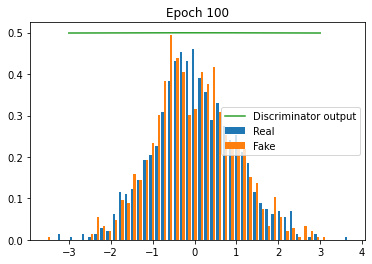

In [13]:
for epoch in range(1, epochs + 1):
    discriminator_loss_epoch = 0
    generator_loss_epoch = 0
    
    for batch_real in train_loader:
        # Train the discriminator
        batch_real = torch.tensor(batch_real, dtype=torch.float)
        batch_real = batch_real.reshape(-1, 1)

        noise = generate_noise(len(batch_real) * generator_input_size)
        noise = torch.tensor(noise, dtype=torch.float)
        noise = noise.reshape(-1, generator_input_size)
        generated = generator(noise)
        
        discriminator_optimizer.zero_grad()
        
        fake = discriminator(generated)
        real = discriminator(batch_real)
        ############### max log(D(x)) + log(1 - D(G(z)))
        lossD_real = criterion(real, torch.ones_like(real))
        lossD_fake = criterion(fake, torch.zeros_like(fake))
        discriminator_loss = (lossD_real + lossD_fake) / 2
        discriminator.zero_grad()
        ###############
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        
        # Train the generator min log(1 - D(G(z))) <-> max log(D(G(z))
        noise = generate_noise(len(batch_real) * generator_input_size)
        noise = torch.tensor(noise, dtype=torch.float)
        noise = noise.reshape(-1, generator_input_size)

        generator_optimizer.zero_grad()
        generated = generator(noise)
        
        fake1 = discriminator(generated)
        
        generator_loss = criterion(fake1, torch.ones_like(fake1))
        generator.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        
        generator_loss_epoch += generator_loss.item() * batch_real.size(0)
        discriminator_loss_epoch += discriminator_loss.item() * batch_real.size(0)

    
    generator_loss_epoch = generator_loss_epoch / len(train_loader.dataset)
    discriminator_loss_epoch = discriminator_loss_epoch / len(train_loader.dataset)
    #print(f"Epoch {epoch}  Generator loss: {generator_loss_epoch:.3}  Discriminator loss: {discriminator_loss_epoch:.3}")
        
    if np.isnan(generator_loss_epoch) or np.isnan(discriminator_loss_epoch):
        print("Breaking due to NaN")
        break
      
    if epoch % 10 == 0:
        print(f"Epoch {epoch}  Generator loss: {generator_loss_epoch:.3}  Discriminator loss: {discriminator_loss_epoch:.3}")
    if epoch % 100 == 0:
        with torch.no_grad():
            real = []
            fake = []
            
            for batch_real in test_loader:
                batch_real = batch_real.float()
                batch_real = batch_real.reshape(-1, 1)
    
                noise = generate_noise(len(batch_real) * generator_input_size)
                noise = torch.tensor(noise, dtype=torch.float)
                noise = noise.reshape(-1, generator_input_size)
                
                generated = generator(noise)

                fake.append(generated)
                real.append(batch_real)
                
            fake = torch.concat(fake)
            real = torch.concat(real)
            
            fake = np.array(fake).reshape(-1)
            real = np.array(real).reshape(-1)
            
            xs_eval = torch.linspace(mean - 3 * std, mean + 3 * std, 1000)

            plt.figure()
            plt.hist([real, fake], label=['Real', 'Fake'], density=True, bins=50)
            plt.plot(xs_eval, discriminator(xs_eval.reshape(-1, 1)), label='Discriminator output')
            plt.legend()
            plt.title(f"Epoch {epoch}")
            plt.show()
        
        # optimizer.zero_grad()
        
        # outputs = model(inputs)
        
        # loss = torch.mean((outputs - labels) ** 2)
        # loss.backward()
        # optimizer.step()
        
        # train_loss += loss.item() * inputs.size(0)
        
    # train_loss = train_loss / len(train_loader.dataset)
    # print(f"Epoch {i+1}: {train_loss}")

In [ ]:
n_training = round(0.9 * len(data))
n_testing = len(data) - n_training
train_data, test_data = torch.utils.data.random_split(data, [n_training, n_testing])

In [28]:
from hyperopt import fmin, tpe, hp, Trials

#from helpers import train_validate

train_validate = data

trials = Trials()

space = {

'activation': hp.choice('activation', [nn.LeakyReLU(), nn.ELU()]),

'epochs': hp.uniform('epochs', 50, 200)

}

best = fmin(fn=tra),

space = space,

algo=tpe.suggest,

max_evals=20*4,

trials = trials)



print(best)

  0%|                                    | 0/80 [00:00<?, ?trial/s, best loss=?]

job exception: name 'validation_loader' is not defined



  0%|                                    | 0/80 [00:00<?, ?trial/s, best loss=?]


NameError: name 'validation_loader' is not defined

In [ ]:
# now with scaling as an option
iris = data
X = iris.data
y = iris.target

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,50)),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best:'
print best